## **FINAL PIPELINE: Punctuation score+RF, TFIDF+RF, Perplexity, Roberta based detector and classifier on the top**

In [1]:
import os 
print(os.getcwd())
os.chdir('../..')
print(os.getcwd())

/home/onyxia/work/ml-for-nlp/analysis/notebooks
/home/onyxia/work/ml-for-nlp


In [2]:
import numpy as np 
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch
from torch.nn.functional import softmax
import matplotlib.pyplot as plt
import seaborn as sns


/usr/local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from src.libs.preprocess_dataframe_train_test import load_all_datasets
from src.pipeline.whole_pipeline import punctuation_map_dimensions_to_names, punctuation_transform, punctuation_map_dimensions_to_names, fit_tfidf_embedding, transform_with_tfidf, train_fine_tune_RF, eval_model, eval_model_binary, evaluate,get_oof_predictions, get_oof_predictions_tfidf

In [4]:
### LOAD DATA

data = load_all_datasets()

### Global X, y
X_train = data["X_train"]
y_train = data["y_train"]
X_test = data["X_test"]
y_test = data["y_test"]

### Global dataframes
df_train = data["df_train"]
df_test = data["df_test"]

### By type: poetry, essay, story (train)
df_train_poetry = data["df_train_poetry"]
df_train_essay = data["df_train_essay"]
df_train_story = data["df_train_story"]
X_train_poetry = data["X_train_poetry"]
y_train_poetry = data["y_train_poetry"]
X_train_essay = data["X_train_essay"]
y_train_essay = data["y_train_essay"]
X_train_story = data["X_train_story"]
y_train_story = data["y_train_story"]

### By type: poetry, essay, story (test)
df_test_poetry = data["df_test_poetry"]
df_test_essay = data["df_test_essay"]
df_test_story = data["df_test_story"]
X_test_poetry = data["X_test_poetry"]
y_test_poetry = data["y_test_poetry"]
X_test_essay = data["X_test_essay"]
y_test_essay = data["y_test_essay"]
X_test_story = data["X_test_story"]
y_test_story = data["y_test_story"]


Time taken to load dataset: 0.040719032287597656 seconds
Time taken to load dataset: 0.01520681381225586 seconds
Time taken to load dataset: 0.5847492218017578 seconds
Time taken to load dataset: 0.024680614471435547 seconds
Time taken to load dataset: 0.017815828323364258 seconds
Time taken to load dataset: 0.1469860076904297 seconds
Time taken to load dataset: 0.027392148971557617 seconds
Time taken to load dataset: 0.02175450325012207 seconds
Time taken to load dataset: 0.02565622329711914 seconds


### **PUNCTUATION**

In [5]:
### EMBEDDING

X_train_punct = punctuation_transform(X_train)
X_test_punct = punctuation_transform(X_test)
X_test_poetry_punct = punctuation_transform(X_test_poetry)
X_test_essay_punct = punctuation_transform(X_test_essay)
X_test_story_punct = punctuation_transform(X_test_story)

In [6]:
### GET score train with CV out of fold
y_proba_train = get_oof_predictions(X_train_punct, y_train, train_fine_tune_RF)

Fold 1/5
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best hyperparameters: {'bootstrap': False, 'max_depth': 14, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 239}
Fold 2/5
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best hyperparameters: {'bootstrap': False, 'max_depth': 14, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 239}
Fold 3/5
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best hyperparameters: {'bootstrap': True, 'max_depth': 18, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 173}
Fold 4/5
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best hyperparameters: {'bootstrap': True, 'max_depth': 19, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 269}
Fold 5/5
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best hyperparameters: {'bootstrap': True, 'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 170}


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best hyperparameters: {'bootstrap': True, 'max_depth': 18, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 173}


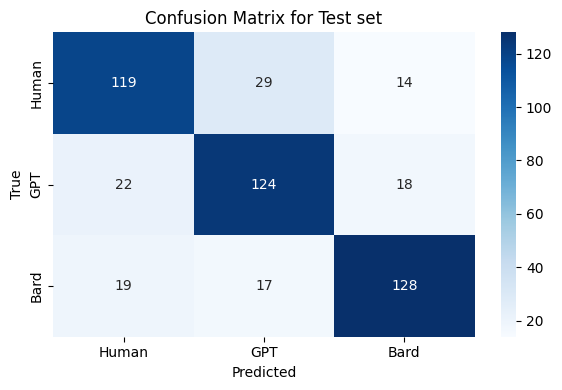

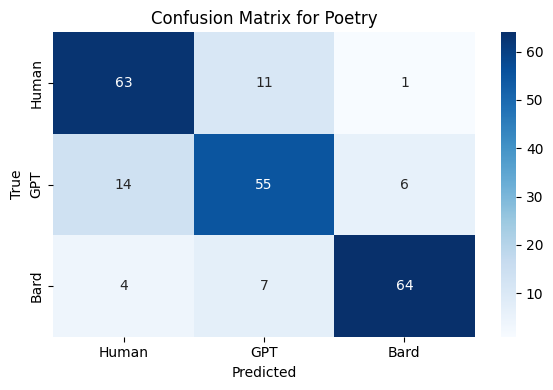

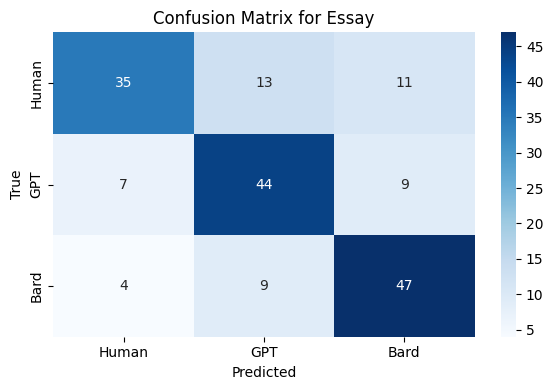

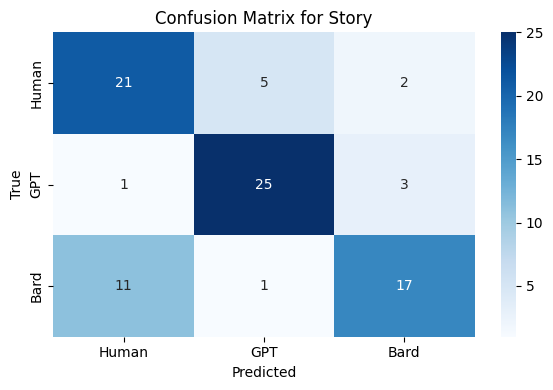

                                     confusion_matrix precision    recall  \
test    [[119, 29, 14], [22, 124, 18], [19, 17, 128]]  0.757721  0.757051   
poetry         [[63, 11, 1], [14, 55, 6], [4, 7, 64]]   0.81087  0.808889   
essay          [[35, 13, 11], [7, 44, 9], [4, 9, 47]]  0.709676  0.703296   
story           [[21, 5, 2], [1, 25, 3], [11, 1, 17]]  0.738514  0.732759   

              f1  
test    0.757256  
poetry  0.809216  
essay   0.701746  
story   0.729508  


In [7]:
classifier_punct = train_fine_tune_RF(X_train_punct, y_train)
eval_model(classifier_punct, X_train_punct, y_train, X_test_punct, y_test, X_test_poetry_punct, y_test_poetry, X_test_essay_punct, y_test_essay, X_test_story_punct, y_test_story)
y_proba_test = classifier_punct.predict_proba(X_test_punct)[:, 1]

In [8]:
df_train["punctuation_score"] = y_proba_train
df_test["punctuation_score"] = y_proba_test

### **TF-IDF**

In [9]:
### TF-IDF embedding
vectorizer_tfidf, X_train_tfidf = fit_tfidf_embedding(X_train, max_features=1000)

X_test_tfidf = transform_with_tfidf(vectorizer_tfidf, X_test)
X_test_poetry_tfidf = transform_with_tfidf(vectorizer_tfidf, X_test_poetry)
X_test_essay_tfidf = transform_with_tfidf(vectorizer_tfidf, X_test_essay)
X_test_story_tfidf = transform_with_tfidf(vectorizer_tfidf, X_test_story)

In [10]:
### GET score train with CV out of fold
y_proba_train = get_oof_predictions_tfidf(X_train_tfidf, y_train, train_fine_tune_RF)

Fold 1/5
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best hyperparameters: {'bootstrap': False, 'max_depth': 19, 'min_samples_leaf': 4, 'min_samples_split': 3, 'n_estimators': 153}
Fold 2/5
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best hyperparameters: {'bootstrap': True, 'max_depth': 19, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 269}
Fold 3/5
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best hyperparameters: {'bootstrap': True, 'max_depth': 18, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 173}
Fold 4/5
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best hyperparameters: {'bootstrap': True, 'max_depth': 19, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 269}
Fold 5/5
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best hyperparameters: {'bootstrap': True, 'max_depth': 18, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 173}


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best hyperparameters: {'bootstrap': False, 'max_depth': 19, 'min_samples_leaf': 4, 'min_samples_split': 3, 'n_estimators': 153}


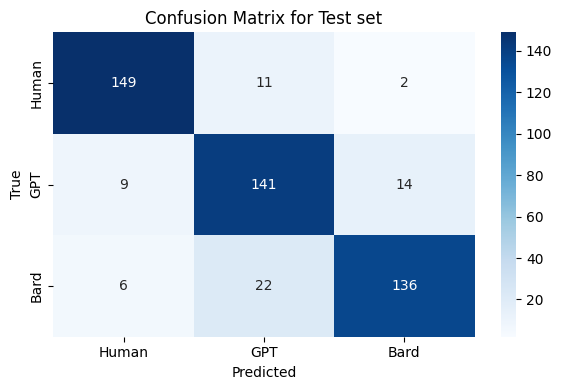

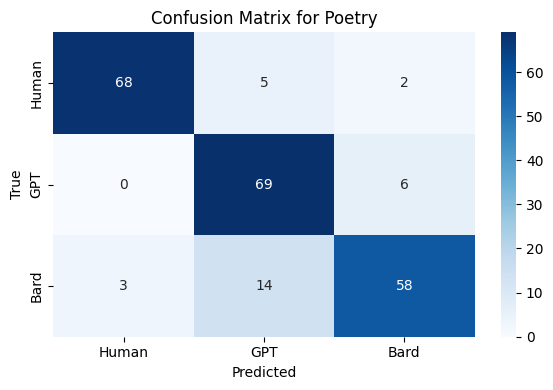

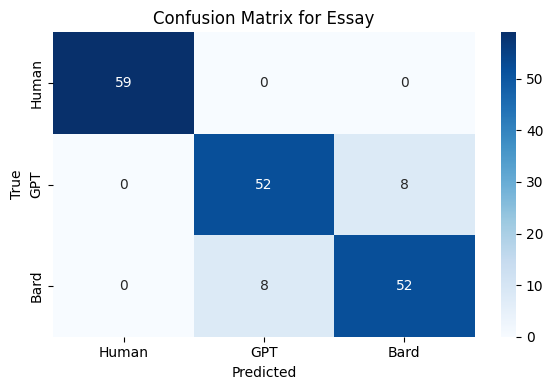

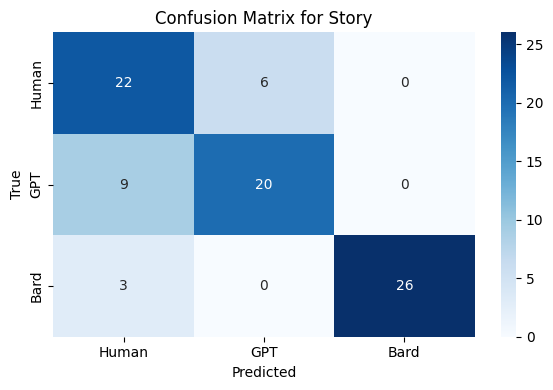

                                  confusion_matrix precision    recall  \
test    [[149, 11, 2], [9, 141, 14], [6, 22, 136]]  0.871206  0.869592   
poetry       [[68, 5, 2], [0, 69, 6], [3, 14, 58]]  0.873542  0.866667   
essay         [[59, 0, 0], [0, 52, 8], [0, 8, 52]]  0.911111  0.911111   
story         [[22, 6, 0], [9, 20, 0], [3, 0, 26]]   0.80543   0.79064   

              f1  
test     0.86973  
poetry  0.866943  
essay   0.911111  
story   0.794135  


In [11]:
classifier_tfidf = train_fine_tune_RF(X_train_tfidf, y_train)
eval_model(classifier_tfidf, X_train_tfidf, y_train, X_test_tfidf, y_test, X_test_poetry_tfidf, y_test_poetry, X_test_essay_tfidf, y_test_essay, X_test_story_tfidf, y_test_story)
y_proba_test = classifier_tfidf.predict_proba(X_test_tfidf)[:, 1]


In [12]:
df_train["tfidf_score"] = y_proba_train
df_test["tfidf_score"] = y_proba_test

### **PERPLEXITY**

In [13]:
### Load pretrained model

tqdm.pandas()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "distilgpt2" 
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [14]:
def compute_perplexity(text):
    """Calcule la perplexité d'un texte avec un modèle de langage causal"""
    try:
        encodings = tokenizer(text, return_tensors="pt", truncation=True, max_length=1024)
        input_ids = encodings["input_ids"].to(device)
        with torch.no_grad():
            outputs = model(input_ids, labels=input_ids)
            loss = outputs.loss
        return torch.exp(loss).item()
    except Exception as e:
        print(f"Erreur pour le texte : {text[:50]}... -> {e}")
        return None

In [15]:
tqdm.pandas()
df_train["perplexity"] = df_train["text"].progress_apply(compute_perplexity)
df_test["perplexity"] = df_test["text"].progress_apply(compute_perplexity)

100%|██████████| 490/490 [00:15<00:00, 32.47it/s]


### **ROBERTA**

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_id = "roberta-base-openai-detector"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSequenceClassification.from_pretrained(model_id).to(device)
model.eval() 

Some weights of the model checkpoint at roberta-base-openai-detector were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [17]:
def detect_score(text):
    try:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(device)
        with torch.no_grad():
            logits = model(**inputs).logits
            probs = softmax(logits, dim=1)
        return probs[0][1].item() 
    except Exception as e:
        print(f"Erreur avec le texte : {e}")
        return None

In [18]:
tqdm.pandas()

df_train["llm_score"] = df_train["text"].progress_apply(detect_score)
df_test["llm_score"] = df_test["text"].progress_apply(detect_score)

100%|██████████| 490/490 [00:15<00:00, 30.87it/s]


## **META CLASSIFIER : MULTICLASS**

In [19]:
X_train_score, y_train = df_train[["punctuation_score",'tfidf_score',"perplexity","llm_score"]].copy(), df_train[["label"]].copy().values.ravel()
X_test_score, y_test = df_test[["punctuation_score",'tfidf_score',"perplexity","llm_score"]].copy(), df_test[["label"]].copy().values.ravel()
X_test_poetry_score, y_test_poetry = df_test[df_test.type=="poetry"][["punctuation_score",'tfidf_score',"perplexity","llm_score"]].copy(), df_test[df_test.type=="poetry"][["label"]].copy().values.ravel()
X_test_story_score, y_test_story = df_test[df_test.type=="story"][["punctuation_score",'tfidf_score',"perplexity","llm_score"]].copy(), df_test[df_test.type=="story"][["label"]].copy().values.ravel()
X_test_essay_score, y_test_essay = df_test[df_test.type=="essay"][["punctuation_score",'tfidf_score',"perplexity","llm_score"]].copy(), df_test[df_test.type=="essay"][["label"]].copy().values.ravel()

In [20]:
meta_classifier = train_fine_tune_RF(X_train_score, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best hyperparameters: {'bootstrap': True, 'max_depth': 16, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 58}


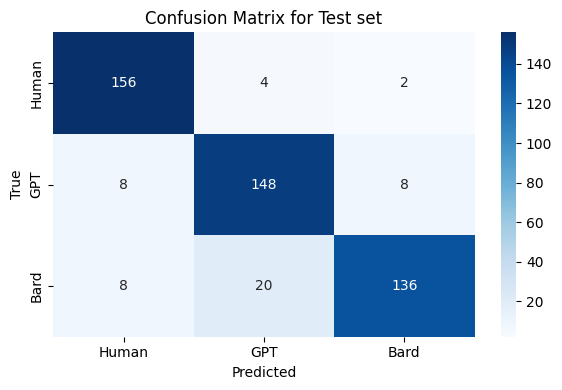

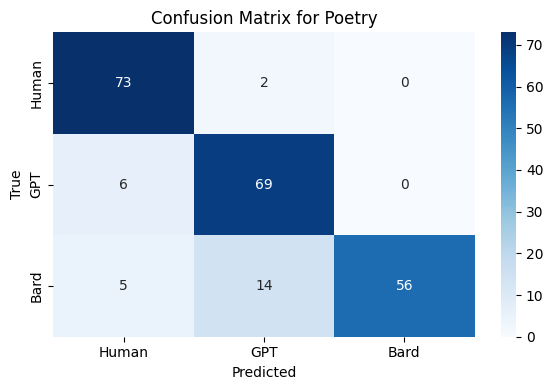

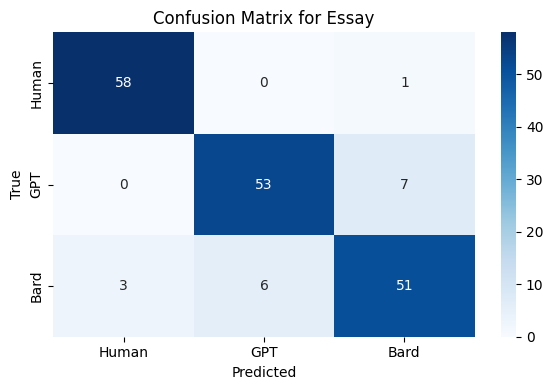

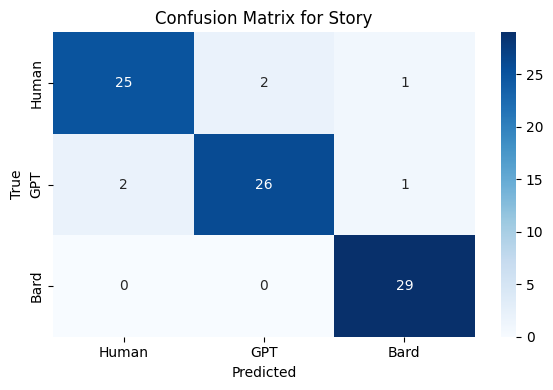

                                confusion_matrix precision    recall        f1
test    [[156, 4, 2], [8, 148, 8], [8, 20, 136]]   0.89965  0.898223  0.897501
poetry     [[73, 2, 0], [6, 69, 0], [5, 14, 56]]  0.893604      0.88  0.878567
essay       [[58, 0, 1], [0, 53, 7], [3, 6, 51]]  0.904511  0.905461  0.904855
story       [[25, 2, 1], [2, 26, 1], [0, 0, 29]]  0.929994  0.929803  0.929346


RandomForestClassifier(max_depth=16, min_samples_leaf=2, min_samples_split=3,
                       n_estimators=58, n_jobs=-1, random_state=42)

In [21]:
eval_model(
    meta_classifier,
    X_train_score, y_train,
    X_test_score, y_test,
    X_test_poetry_score, y_test_poetry,
    X_test_essay_score, y_test_essay,
    X_test_story_score, y_test_story
)
